This notebook runs sklearn classifiers on the filtered data which is made by the DataPreprocessing notebook. Graphs for the classifier accuracy, feature importance, and confusion matrix are created. 

In [1]:
# Render our plots inline
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# First read the data
input_file = "cardio_train_filtered.csv"
cardio_train = pd.read_csv(input_file)



In [2]:

def plot_confusion_matrix(class_names,cnf_matrix,name):
    '''Creates a confusion matrix to show how the classifier predicted. A confusion matrix consists of
    two rows and two columns for a binary classifier and displays such that the actual and predicted 
    values for different classes.'''
    
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap on the right
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    title = name 
    plt.title(title, y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    
def print_perm_importance(feature_cols,mean,std):
    '''Prints the permutation importance in an organized manner, such that the reader can see the mean weight
    and standard deviation of the features after calling permutation_importance from sklearn'''
    order = np.argsort(mean)[::-1]
    for id in order:
           print('{feat:<30}  {mean: .4f} \t\t {std: .4f}'.format(feat = feature_cols[id], mean = mean[id], std = std[id]))

            
def find_best_classifier(X_train,X_test,y_train,y_test):
    '''Runs all three classifiers on the training set, and then sees which one has the highest accuracy
    on the testing set. Returns the classifier with the best accuracy and the list of accuracies. '''
    #Calculating accuracy for logistic regression
    logreg = LogisticRegression()
    logreg.fit(X_train,y_train)
    y_pred=logreg.predict(X_test) 
    logreg_accuracy = metrics.accuracy_score(y_test,y_pred)
    
    #Calculating accuracy for decision tree
    dectree = DecisionTreeClassifier()
    dectree.fit(X_train,y_train)
    y_pred = dectree.predict(X_test)
    decision_tree_accuracy = metrics.accuracy_score(y_test,y_pred)
    
    #Calculating accuracy for random forest
    randomforest = RandomForestClassifier(n_estimators = 16)
    randomforest.fit(X_train,y_train)
    y_pred = randomforest.predict(X_test)
    random_forest_accuracy = metrics.accuracy_score(y_test,y_pred)
    

    classifier_list = [logreg,dectree,randomforest]
    accuracy_list = [logreg_accuracy,decision_tree_accuracy,random_forest_accuracy]
    classifier_index = accuracy_list.index(max(accuracy_list))
    return classifier_list[classifier_index],accuracy_list

def draw_perm_plot(feat_names,mean):
    '''Displaying the permutation importance bar plot for the whole dataset'''
    #sorts the permutation importance means in order largest to smallest
    unsorted_perm = np.abs(mean)
    sorted_order = np.argsort(unsorted_perm)[::-1]
    sorted_perm = unsorted_perm[sorted_order]
    sorted_feat_names = []
    for idx in sorted_order:
        sorted_feat_names.append(feat_names[idx])
    #displaying the plot
    plt.bar(sorted_feat_names,sorted_perm,width=0.5, color=(0.4,0.9,1,1))
    ax = plt.gca()
    plt.grid()
    #set title, labels
    plt.title('Feature Importance: Entire Dataset',fontweight='bold',fontsize=20)
    plt.xlabel('Feature')
    plt.ylabel('Feature importance')
    plt.setp(ax.get_xticklabels(),fontsize=10,rotation=45)

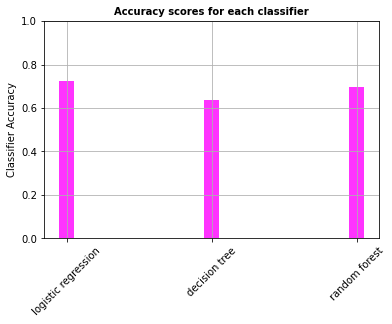

In [10]:
#displaying plot for the classifier accuracies
feature_cols = list(cardio_train.columns)[:-1]

X=cardio_train[feature_cols] 
y=cardio_train.cardio

#splitting the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.25,random_state=0)

accuracy_list = find_best_classifier(X_train,X_test,y_train,y_test)[1]
plt.bar(['logistic regression','decision tree','random forest'],accuracy_list,width=0.1,color=(1,0.2,1,1))
ax = plt.gca()
plt.grid()
plt.title('Accuracy scores for each classifier',fontweight='bold',fontsize=10)
plt.ylabel('Classifier Accuracy')
plt.setp(ax.get_xticklabels(),fontsize=10,rotation=45)
plt.ylim([0,1])
plt.savefig("accuracy_classifier_bar_plot",bbox_inches='tight')

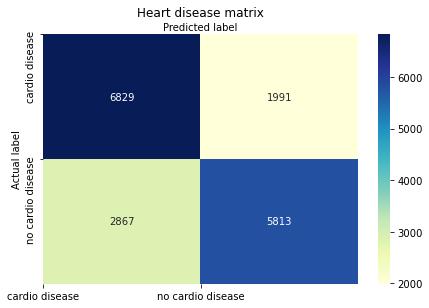

In [3]:
#running classifier on whole dataset, displaying confusion matrix
best_classifier_info = find_best_classifier(X_train,X_test,y_train,y_test)
best_classifier = best_classifier_info[0]
y_pred = best_classifier.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
plot_confusion_matrix(['cardio disease','no cardio disease'],cnf_matrix,'Heart disease matrix')
plt.savefig("log_reg_conf_matrix",bbox_inches='tight')

systolic                         0.1331 		  0.0020
cholesterol                      0.0305 		  0.0013
age                              0.0236 		  0.0011
bmi                              0.0080 		  0.0009
active                           0.0017 		  0.0005
glucose                          0.0013 		  0.0004
smoking                          0.0009 		  0.0002
alchoholic                       0.0006 		  0.0002
diastolic                        0.0005 		  0.0002
gender                          -0.0001 		  0.0003


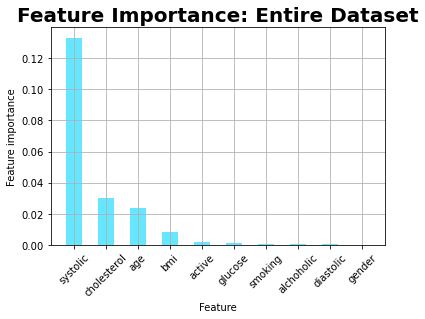

In [5]:
#displaying permutation plot and printing permutation importance data (whole dataset)
result = permutation_importance(best_classifier,X_train,y_train,n_repeats=30,random_state=0)
print_perm_importance(feature_cols,result.importances_mean,result.importances_std)
draw_perm_plot(feature_cols,result.importances_mean)
plt.savefig("permutation_importance_bar_plot",bbox_inches='tight')
plt.show()

In [11]:
#defining female dataset training and testing, male dataset training and testing
female = cardio_train[cardio_train["gender"]<0]
female_X=female[feature_cols]
female_y=female.cardio
female_X_train,female_X_test,female_y_train,female_y_test = train_test_split(female_X,female_y,test_size =0.25,random_state=0)
male = cardio_train[cardio_train["gender"] > 0]
male_X=male[feature_cols]
male_y=male.cardio
male_X_train,male_X_test,male_y_train,male_y_test = train_test_split(male_X,male_y,test_size =0.25,random_state=0)

systolic                         0.1411 		  0.0021
cholesterol                      0.0271 		  0.0013
age                              0.0245 		  0.0016
bmi                              0.0052 		  0.0011
active                           0.0007 		  0.0004
glucose                          0.0006 		  0.0005
diastolic                        0.0002 		  0.0002
alchoholic                       0.0002 		  0.0002
smoking                          0.0001 		  0.0000
gender                           0.0000 		  0.0000


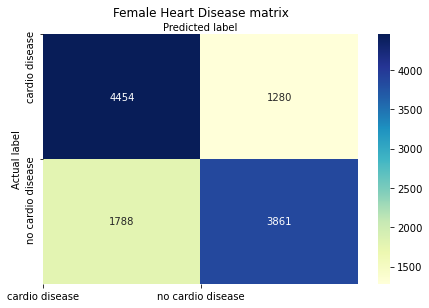

In [9]:
#running classifier on female dataset, and displaying conf matrix
female_info = find_best_classifier(female_X_train,female_X_test,female_y_train,female_y_test)
female_classifier = female_info[0]
result = permutation_importance(female_classifier,female_X_train,female_y_train,n_repeats=30,random_state=0)
print_perm_importance(feature_cols,result.importances_mean,result.importances_std)
female_y_pred = best_classifier.predict(female_X_test)
cnf_matrix = metrics.confusion_matrix(female_y_test,female_y_pred)
plot_confusion_matrix(['cardio disease','no cardio disease'],cnf_matrix,'Female Heart Disease matrix')

In [ ]:
#running classifier on male dataset, and displaying conf matrix
male_classifier = find_best_classifier(male_X_train,male_X_test,male_y_train,male_y_test)[0]

result = permutation_importance(male_classifier,male_X_train,male_y_train,n_repeats=30,random_state=0)
print_perm_importance(feature_cols,result.importances_mean,result.importances_std)
male_y_pred = best_classifier.predict(male_X_test)
cnf_matrix = metrics.confusion_matrix(male_y_test,male_y_pred)
plot_confusion_matrix(['cardio disease','no cardio disease'],cnf_matrix,'Male heart disease matrix')